<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/master/C1/W2/ungraded_labs/C1_W2_Lab_1_beyond_hello_world.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Beyond Hello World, A Computer Vision Example
In the previous exercise, you saw how to create a neural network that figured out the problem you were trying to solve. This gave an explicit example of learned behavior. Of course, in that instance, it was a bit of overkill because it would have been easier to write the function `y=2x-1` directly instead of bothering with using machine learning to learn the relationship between `x` and `y`.

But what about a scenario where writing rules like that is much more difficult -- for example a computer vision problem? Let's take a look at a scenario where you will build a neural network to recognize different items of clothing, trained from a dataset containing 10 different types.

## Start Coding

Let's start with our import of TensorFlow.

In [1]:
import os
import tensorflow as tf
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
print(f'Tensorflow version: {tf.__version__}')

# NumPy version 1.23.4 to avoid version conflicts
# Python version 3.9.19 to avoid version conflicts
# Tensorflow was installed using the package tensorflow-gpu
physical_devices = tf.config.list_physical_devices("GPU")
# tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices)

2024-05-11 14:33:50.309851: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Tensorflow version: 2.4.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-05-11 14:33:51.077327: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-05-11 14:33:51.079029: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-05-11 14:33:51.147370: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-11 14:33:51.147501: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.86GHz coreCount: 82 deviceMemorySize: 23.67GiB deviceMemoryBandwidth: 871.81GiB/s
2024-05-11 14:33:51.147517: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-05-11 14:33:51.159395: I tensorflow/stream_executor/platform/de

The [Fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) is a collection of grayscale 28x28 pixel clothing images. Each image is associated with a label as shown in this table⁉

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

This dataset is available directly in the [tf.keras.datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets) API and you load it like this:

In [11]:
# Load the Fashion MNIST dataset
fmnist = tf.keras.datasets.fashion_mnist        

Tensorflow Fashion mnist dataset [URL](https://www.tensorflow.org/datasets/catalog/fashion_mnist)

Calling `load_data()` on this object will give you two tuples with two lists each. These will be the training and testing values for the graphics that contain the clothing items and their labels.


In [12]:
# Load the training and test split of the Fashion MNIST dataset
(training_images, training_labels), (test_images, test_labels) = fmnist.load_data()

What do these values look like? Let's print a training image (both as an image and a numpy array), and a training label to see. Experiment with different indices in the array. For example, also take a look at index `42`. That's a different boot than the one at index `0`.


LABEL: 4

IMAGE PIXEL ARRAY:
 [[  0   0   0   0   0   0   0   0   0   0  22 110 118 148 144 145 149 156  61   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   1   0  11 217 255 255 255 255 255 255 255 241   1   0   1   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   1   0  15 234 220 236 246 247 247 245 242 240 164   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  12 141 236 221 216 248 246 255 234 209 208 194   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0  49 220 230 230 236 242 236 227 228 204 227 220 210 201  77   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 181 219 207 214 212 207 223 222 214 220 211 213 204 202 181   0   0   0   0   0   0]
 [  0   0   0   0   0   0   4 218 219 212 211 209 206 200 207 199 192 204 203 188 195 203  41   0   0   0   0   0]
 [  0   0   0   0   0   0  54 229 220 213 212 209 205 201 194 199 195 195 187 192 201 205  80   0   0   0   0   0]
 [  0   0   0   0   0   0  96 236 223 207 211 204 

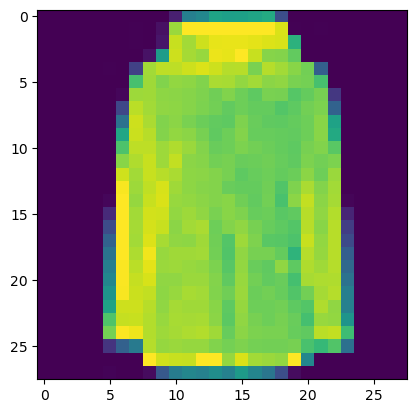

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# You can put between 0 to 59999 here
index = 11111

# Set number of characters per row when printing
np.set_printoptions(linewidth=320)

# Print the label and image
print(f'LABEL: {training_labels[index]}')
print(f'\nIMAGE PIXEL ARRAY:\n {training_images[index]}')

# Visualize the image
plt.imshow(training_images[index])

You'll notice that all of the values in the number are between 0 and 255. If you are training a neural network especially in image processing, for various reasons it will usually learn better if you scale all values to between 0 and 1. It's a process called _normalization_ and fortunately in Python, it's easy to normalize an array without looping. You do it like this:

In [15]:
# Normalize the pixel values of the train and test images
training_images  = training_images / 255.0
test_images = test_images / 255.0

Now you might be wondering why the dataset is split into two: training and testing? Remember we spoke about this in the intro? The idea is to have 1 set of data for training, and then another set of data that the model hasn't yet seen. This will be used to evaluate how good it would be at classifying values.

Let's now design the model. There's quite a few new concepts here. But don't worry, you'll get the hang of them. 

In [18]:
# Build the classification model
model = tf.keras.models.Sequential([tf.keras.layers.Flatten(), 
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(10, activation=tf.nn.softmax)])

[Sequential](https://keras.io/api/models/sequential/): That defines a sequence of layers in the neural network.

[Flatten](https://keras.io/api/layers/reshaping_layers/flatten/): Remember earlier where our images were a 28x28 pixel matrix when you printed them out? Flatten just takes that square and turns it into a 1-dimensional array.

[Dense](https://keras.io/api/layers/core_layers/dense/): Adds a layer of neurons

Each layer of neurons need an [activation function](https://keras.io/api/layers/activations/) to tell them what to do. There are a lot of options, but just use these for now: 

[ReLU](https://keras.io/api/layers/activations/#relu-function) effectively means:

```
if x > 0: 
  return x

else: 
  return 0
```

In other words, it only passes values greater than 0 to the next layer in the network.

[Softmax](https://keras.io/api/layers/activations/#softmax-function) takes a list of values and scales these so the sum of all elements will be equal to 1. When applied to model outputs, you can think of the scaled values as the probability for that class. For example, in your classification model which has 10 units in the output dense layer, having the highest value at `index = 4` means that the model is most confident that the input clothing image is a coat. If it is at index = 5, then it is a sandal, and so forth. See the short code block below which demonstrates these concepts. You can also watch this [lecture](https://www.youtube.com/watch?v=LLux1SW--oM&ab_channel=DeepLearningAI) if you want to know more about the Softmax function and how the values are computed.


In [7]:
# Declare sample inputs and convert to a tensor
inputs = np.array([[1.0, 3.0, 4.0, 2.0]])
inputs = tf.convert_to_tensor(inputs)
print(f'input to softmax function: {inputs.numpy()}')

# Feed the inputs to a softmax activation function
outputs = tf.keras.activations.softmax(inputs)
print(f'output of softmax function: {outputs.numpy()}')

# Get the sum of all values after the softmax
sum = tf.reduce_sum(outputs)
print(f'sum of outputs: {sum}')

# Get the index with highest value
prediction = np.argmax(outputs)
print(f'class with highest probability: {prediction}')

input to softmax function: [[1. 3. 4. 2.]]
output of softmax function: [[0.0320586  0.23688282 0.64391426 0.08714432]]
sum of outputs: 0.9999999999999999
class with highest probability: 2


The next thing to do, now that the model is defined, is to actually build it. You do this by compiling it with an optimizer and loss function as before -- and then you train it by calling `model.fit()` asking it to fit your training data to your training labels. It will figure out the relationship between the training data and its actual labels so in the future if you have inputs that looks like the training data, then it can predict what the label for that input is.

In [19]:
model.compile(optimizer = tf.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy']) 

model.fit(training_images, training_labels, epochs=20)

Epoch 1/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6315 - accuracy: 0.7788
Epoch 2/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3759 - accuracy: 0.8617
Epoch 3/20
1875/1875 [==============================] - 2s 930us/step - loss: 0.3307 - accuracy: 0.8774
Epoch 4/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3079 - accuracy: 0.8837
Epoch 5/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2877 - accuracy: 0.8909
Epoch 6/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2682 - accuracy: 0.8999
Epoch 7/20
1875/1875 [==============================] - 2s 917us/step - loss: 0.2579 - accuracy: 0.9030
Epoch 8/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2432 - accuracy: 0.9084
Epoch 9/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2343 - accuracy: 0.9107
Epoch 10/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0

Once it's done training -- you should see an accuracy value at the end of the final epoch. It might look something like `0.9098`. This tells you that your neural network is about 91% accurate in classifying the training data. That is, it figured out a pattern match between the image and the labels that worked 91% of the time. Not great, but not bad considering it was only trained for 5 epochs and done quite quickly.

But how would it work with unseen data? That's why we have the test images and labels. We can call [`model.evaluate()`](https://keras.io/api/models/model_training_apis/#evaluate-method) with this test dataset as inputs and it will report back the loss and accuracy of the model. Let's give it a try:

In [9]:
# Evaluate the model on unseen data
model.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 2ms/step - loss: 0.3506 - accuracy: 0.8717


[0.3505585789680481, 0.8716999888420105]

You can expect the accuracy here to be about `0.88` which means it was 88% accurate on the entire test set. As expected, it probably would not do as well with *unseen* data as it did with data it was trained on!  As you go through this course, you'll look at ways to improve this. 

# Exploration Exercises

To explore further and deepen your understanding, try the below exercises:

### Exercise 1:
For this first exercise run the below code: It creates a set of classifications for each of the test images, and then prints the first entry in the classifications. The output, after you run it is a list of numbers. Why do you think this is, and what do those numbers represent? 

In [ ]:
classifications = model.predict(test_images)

print(classifications[0])

**Hint:** try running `print(test_labels[0])` -- and you'll get a `9`. Does that help you understand why this list looks the way it does? 

In [ ]:
print(test_labels[0])

### E1Q1: What does this list represent?


1.   It's 10 random meaningless values
2.   It's the first 10 classifications that the computer made
3.   It's the probability that this item is each of the 10 classes


<details><summary>Click for Answer</summary>
<p>

#### Answer: 
The correct answer is (3)

The output of the model is a list of 10 numbers. These numbers are a probability that the value being classified is the corresponding value (https://github.com/zalandoresearch/fashion-mnist#labels), i.e. the first value in the list is the probability that the image is of a '0' (T-shirt/top), the next is a '1' (Trouser) etc. Notice that they are all VERY LOW probabilities.

For index 9 (Ankle boot), the probability was in the 90's, i.e. the neural network is telling us that the image is most likely an ankle boot.

</p>
</details>

### E1Q2: How do you know that this list tells you that the item is an ankle boot?


1.   There's not enough information to answer that question
2.   The 10th element on the list is the biggest, and the ankle boot is labelled 9
2.   The ankle boot is label 9, and there are 0->9 elements in the list


<details><summary>Click for Answer</summary>
<p>

#### Answer
The correct answer is (2). Both the list and the labels are 0 based, so the ankle boot having label 9 means that it is the 10th of the 10 classes. The list having the 10th element being the highest value means that the Neural Network has predicted that the item it is classifying is most likely an ankle boot

</p>
</details>

### Exercise 2: 
Let's now look at the layers in your model. Experiment with different values for the dense layer with 512 neurons. What different results do you get for loss, training time etc? Why do you think that's the case? 


In [ ]:
fmnist = tf.keras.datasets.fashion_mnist

(training_images, training_labels) ,  (test_images, test_labels) = fmnist.load_data()

training_images = training_images/255.0
test_images = test_images/255.0

model = tf.keras.models.Sequential([tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(512, activation=tf.nn.relu), # Try experimenting with this layer
                                    tf.keras.layers.Dense(10, activation=tf.nn.softmax)])

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy')

model.fit(training_images, training_labels, epochs=5)

model.evaluate(test_images, test_labels)

classifications = model.predict(test_images)

print(classifications[0])
print(test_labels[0])

### E2Q1: Increase to 1024 Neurons -- What's the impact?

1. Training takes longer, but is more accurate
2. Training takes longer, but no impact on accuracy
3. Training takes the same time, but is more accurate


<details><summary>Click for Answer</summary>
<p>

#### Answer
The correct answer is (1) by adding more Neurons we have to do more calculations, slowing down the process, but in this case they have a good impact -- we do get more accurate. That doesn't mean it's always a case of 'more is better', you can hit the law of diminishing returns very quickly!

</p>
</details>

### Exercise 3: 

### E3Q1: What would happen if you remove the Flatten() layer. Why do you think that's the case? 

<details><summary>Click for Answer</summary>
<p>

#### Answer
You get an error about the shape of the data. It may seem vague right now, but it reinforces the rule of thumb that the first layer in your network should be the same shape as your data. Right now our data is 28x28 images, and 28 layers of 28 neurons would be infeasible, so it makes more sense to 'flatten' that 28,28 into a 784x1. Instead of writing all the code to handle that ourselves, we add the Flatten() layer at the begining, and when the arrays are loaded into the model later, they'll automatically be flattened for us.

</p>
</details>

In [ ]:
fmnist = tf.keras.datasets.fashion_mnist

(training_images, training_labels) ,  (test_images, test_labels) = fmnist.load_data()

training_images = training_images/255.0
test_images = test_images/255.0

model = tf.keras.models.Sequential([tf.keras.layers.Flatten(), #Try removing this layer
                                    tf.keras.layers.Dense(64, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(10, activation=tf.nn.softmax)])

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy')

model.fit(training_images, training_labels, epochs=5)

model.evaluate(test_images, test_labels)

classifications = model.predict(test_images)

print(classifications[0])
print(test_labels[0])

### Exercise 4: 

Consider the final (output) layers. Why are there 10 of them? What would happen if you had a different amount than 10? For example, try training the network with 5.

<details><summary>Click for Answer</summary>
<p>

#### Answer
You get an error as soon as it finds an unexpected value. Another rule of thumb -- the number of neurons in the last layer should match the number of classes you are classifying for. In this case it's the digits 0-9, so there are 10 of them, hence you should have 10 neurons in your final layer.

</p>
</details>

In [ ]:
fmnist = tf.keras.datasets.fashion_mnist

(training_images, training_labels) ,  (test_images, test_labels) = fmnist.load_data()

training_images = training_images/255.0
test_images = test_images/255.0

model = tf.keras.models.Sequential([tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(64, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(10, activation=tf.nn.softmax) # Try experimenting with this layer
                                  ])

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy')

model.fit(training_images, training_labels, epochs=5)

model.evaluate(test_images, test_labels)

classifications = model.predict(test_images)

print(classifications[0])
print(test_labels[0])

### Exercise 5: 

Consider the effects of additional layers in the network. What will happen if you add another layer between the one with 512 and the final layer with 10. 

<details><summary>Click for Answer</summary>
<p>

#### Answer 
There isn't a significant impact -- because this is relatively simple data. For far more complex data (including color images to be classified as flowers that you'll see in the next lesson), extra layers are often necessary. 

</p>
</details>

In [ ]:
fmnist = tf.keras.datasets.fashion_mnist

(training_images, training_labels) ,  (test_images, test_labels) = fmnist.load_data()

training_images = training_images/255.0
test_images = test_images/255.0

model = tf.keras.models.Sequential([tf.keras.layers.Flatten(),
                                    # Add a layer here,
                                    tf.keras.layers.Dense(256, activation=tf.nn.relu),
                                    # Add a layer here
                                  ])

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy')

model.fit(training_images, training_labels, epochs=5)

model.evaluate(test_images, test_labels)

classifications = model.predict(test_images)

print(classifications[0])
print(test_labels[0])

### Exercise 6: 

### E6Q1: Consider the impact of training for more or less epochs. Why do you think that would be the case? 

- Try 15 epochs -- you'll probably get a model with a much better loss than the one with 5
- Try 30 epochs -- you might see the loss value decrease more slowly, and sometimes increases. You'll also likely see that the results of `model.evaluate()` didn't improve much. It can even be slightly worse.

This is a side effect of something called 'overfitting' which you can learn about later and it's something you need to keep an eye out for when training neural networks. There's no point in wasting your time training if you aren't improving your loss, right! :)

In [ ]:
fmnist = tf.keras.datasets.fashion_mnist

(training_images, training_labels) ,  (test_images, test_labels) = fmnist.load_data()

training_images = training_images/255.0
test_images = test_images/255.0

model = tf.keras.models.Sequential([tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(10, activation=tf.nn.softmax)])

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy')

model.fit(training_images, training_labels, epochs=15) # Experiment with the number of epochs

model.evaluate(test_images, test_labels)


### Exercise 7: 

Before you trained, you normalized the data, going from values that were 0-255 to values that were 0-1. What would be the impact of removing that? Here's the complete code to give it a try. Why do you think you get different results? 

In [ ]:
fmnist = tf.keras.datasets.fashion_mnist

(training_images, training_labels) ,  (test_images, test_labels) = fmnist.load_data()

training_images=training_images/255.0 # Experiment with removing this line
test_images=test_images/255.0 # Experiment with removing this line
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.fit(training_images, training_labels, epochs=5)
model.evaluate(test_images, test_labels)
classifications = model.predict(test_images)
print(classifications[0])
print(test_labels[0])

### Exercise 8: 

Earlier when you trained for extra epochs you had an issue where your loss might change. It might have taken a bit of time for you to wait for the training to do that, and you might have thought 'wouldn't it be nice if I could stop the training when I reach a desired value?' -- i.e. 60% accuracy might be enough for you, and if you reach that after 3 epochs, why sit around waiting for it to finish a lot more epochs....So how would you fix that? Like any other program...you have callbacks! Let's see them in action...

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') >= 0.6): # Experiment with changing this value
      print("\nReached 60% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

fmnist = tf.keras.datasets.fashion_mnist
(training_images, training_labels) ,  (test_images, test_labels) = fmnist.load_data()

training_images=training_images/255.0
test_images=test_images/255.0
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(training_images, training_labels, epochs=5, callbacks=[callbacks])
